# Semi-supervized VAE StarNet


* Inputs: APOGEE DR12 real spectra and simulated spectra with ASSET
* Outputs: stellar parameters from ASSET

This notebook goes through the building and training of two VAE models in series.

In [5]:
import numpy as np
import time
import h5py
import keras
import matplotlib.pyplot as plt
import math

import sys

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, 
                          Dropout, Conv1D, UpSampling1D, MaxPooling1D, ZeroPadding1D, LeakyReLU, AveragePooling1D)
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras import metrics
from keras import backend as K

from keras.engine.topology import Layer

from keras import regularizers

import keras.initializers
from keras_contrib.layers import InstanceNormalization

plt.switch_backend('agg')

### Data loading and normalization

Some helper functions for the data.

In [2]:
def load_train_data_weighted_with_asset(data_file_l,data_file_u,indices_l=None,indices_u=None,
                                       unlabeled=True,labeled=True):
    # load APOGEE spectra
    if unlabeled:
        # Grab all
        if indices_u is None:
            with h5py.File(data_file_u,"r") as F:
                ap_spectra = F['APOGEE spectrum'][:]
                ap_err_spectra = F['APOGEE error_spectrum'][:]
                ap_labels = np.column_stack((F['APOGEE TEFF'][:],F['APOGEE LOGG'][:],F['APOGEE FE_H'][:],
                                            F['APOGEE alpha_M'][:],F['APOGEE N_M'][:],F['APOGEE C_M'][:]))
        # Grab a batch
        else:            
            with h5py.File(data_file_u, "r") as F:
                indices_bool = np.ones((len(F['APOGEE spectrum']),),dtype=bool)
                indices_bool[:] = False
                indices_bool[indices_u] = True 

                ap_spectra = F['APOGEE spectrum'][indices_bool,:]
                ap_err_spectra = F['APOGEE error_spectrum'][indices_bool,:]
                ap_labels = np.column_stack((F['APOGEE TEFF'][indices_bool],F['APOGEE LOGG'][indices_bool],
                                         F['APOGEE FE_H'][indices_bool], F['APOGEE alpha_M'][indices_bool],
                                         F['APOGEE N_M'][indices_bool],F['APOGEE C_M'][indices_bool]))
    else:
        ap_spectra=[]
        ap_err_spectra=[]
        ap_labels=[]
        
    # load ASSET spectra
    if labeled:
        # Grab all
        if indices_l is None:
            with h5py.File(data_file_l,"r") as F:    
                synth_spectra = F['spectrum'][:]
                synth_labels = np.column_stack((F['teff'][:],F['logg'][:],F['M_H'][:],
                                                F['a_M'][:],F['N_M'][:],F['C_M'][:]))  
                
                bad_spectra = list(set(list(np.where(synth_spectra<0.)[0])))
                for index in sorted(bad_spectra, reverse=True):
                    del synth_spectra[index]
                    del synth_labels[index]
        # Grab a batch
        else:
            with h5py.File(data_file_l, "r") as F:
                indices_bool = np.ones((len(F['spectrum']),),dtype=bool)
                indices_bool[:] = False
                indices_bool[indices_l] = True 

                synth_spectra = F['spectrum'][indices_bool,:]
                synth_labels = np.column_stack((F['teff'][indices_bool],F['logg'][indices_bool],F['M_H'][indices_bool],
                                                F['a_M'][indices_bool],F['N_M'][indices_bool],F['C_M'][indices_bool]))
                
                synth_spectra=list(synth_spectra)
                synth_labels=list(synth_labels)
                bad_spectra = list(set(list(np.where(synth_spectra<0.)[0])))
                for index in sorted(bad_spectra, reverse=True):
                    del synth_spectra[index]
                    del synth_labels[index]
                synth_spectra=np.array(synth_spectra)
                synth_labels=np.array(synth_labels)
    else:
        synth_spectra=[]
        synth_labels=[]

    return ap_spectra,ap_err_spectra,ap_labels,synth_spectra,synth_labels

# normalize label variables to have zero-mean and unit-variance
def normalize(lb,mean_and_std_file='/data/stars/apogee/dr12/asset_labels_mean_and_std.npy'):
    mean_and_std = np.load(mean_and_std_file)
    return (lb-mean_and_std[0])/mean_and_std[1]

def denormalize(lb_norm,mean_and_std_file='/data/stars/apogee/dr12/asset_labels_mean_and_std.npy'):
    mean_and_std = np.load(mean_and_std_file)
    return ((lb_norm*mean_and_std[1]) + mean_and_std[0])

# normalize each spectrum to have zero-mean and unit-variance (ignore zero-values whe calculating mean and std)
def normalize_spec(specs):
    specs[specs == 0] = np.nan
    mean_spec = np.nanmean(specs,axis=1).reshape(len(specs),1)
    std_spec = np.nanstd(specs,axis=1).reshape(len(specs),1)
    specs[np.isnan(specs)] = 0.
    return (specs-mean_spec)/std_spec

In [3]:
# function for reshaping spectra into appropriate format for CNN
def cnn_reshape(spectra):
    return spectra.reshape(spectra.shape[0],spectra.shape[1],1)

In [4]:
# Set some model hyper-parameters

img_cols, img_chns = 7214, 1  
num_fluxes=7214
input_shape=(num_fluxes,1)
z_dims = 16
num_labels=6
batch_size = 64
epsilon_std = 1.0
learning_rate = 0.001
decay = 0.0
var_epsilon = 0.010

padding=u'same'
kernel_init = 'he_normal'
bias_init = keras.initializers.Zeros()

num_filters = [16, 16]
filter_length = 3
pool_length = 4
num_hidden = [256,128]

## Zero-Augmentation


In an effort to evenly distribute the weighting of the VAE, throughout training, a *zero-augmentation* technique was applied to the training spectra samples - both synthetic and observed. 

The zero-augmentation is implemented as the first layer in the encoder where a zero-augmentation mask is sent as an input along with the input spectrum and the two are multiplied together. 

The zero-augmentation mask is the same size as the input spectrum vector and is composed of ones and zeros. For the APOGEE wave-grid, the spectral region is divided into seven *chunks* and for each input spectrum a random 0-3 of these chunks are assigned to be zeros while the remainder of the zero-augmentation mask is made up of ones. This means for a given spectrum, the input for training may be 4/7ths, 5/7ths, 6/7ths, or the entire spectrum. This augmentation is done randomly throughout training, meaning that each spectrum will be randomly assigned a different zero-augmentation mask at every iteration.

In [5]:
# zero-augmentation layer
class ZeroAugmentLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(ZeroAugmentLayer, self).__init__(**kwargs)

    def zero_agument(self, x_real, zero_mask):
        return x_real*zero_mask

    def call(self, inputs):
        x_real = inputs[0]
        zero_mask = inputs[1]
        x_augmented = self.zero_agument(x_real, zero_mask)

        return x_augmented

# a function for creating the zero-masks used during training
def create_zero_mask(spectra,min_chunks,max_chunks,chunk_size,dataset=None,ones_padded=False):
    if dataset is None:
        zero_mask = np.ones_like(spectra)
    elif dataset=='apogee':
        zero_mask = np.ones((spectra.shape[0],7214))
    elif dataset=='segue':
        zero_mask = np.ones((spectra.shape[0],3688))
    
    num_spec = zero_mask.shape[0]
    len_spec = zero_mask.shape[1]
    num_bins = len_spec/chunk_size
    remainder = len_spec%chunk_size
    spec_sizes = np.array([chunk_size for i in range(num_bins)])
    spec_sizes[-1]=spec_sizes[-1]+remainder
    

    num_bins_removed = np.random.randint(min_chunks,max_chunks+1,size=(num_spec,))
    for i, mask in enumerate(zero_mask):
        bin_indx_removed = np.random.choice(num_bins, num_bins_removed[i], replace=False)
        for indx in bin_indx_removed:
            if indx==0:
                mask[indx*spec_sizes[indx]:(indx+1)*spec_sizes[indx]]=0.
            else:
                mask[indx*spec_sizes[indx-1]:indx*spec_sizes[indx-1]+spec_sizes[indx]]=0.

    return zero_mask        

In [6]:
def set_trainable(model, train):
    """
    Enable or disable training for the model
    """
    model.trainable = train
    for l in model.layers:
        l.trainable = train

# Build encoder

Takes spectra (x) and zero-augmentation mask as inputs and outputs latent distribution (z_mean and z_log_var). If the encoder is for the labeled data, the outputs will also include the stellar parameter distribution (y_mean and y_log_var)

In [7]:
def build_encoder(input_spec,input_mask,labeled=False):
    
    # input conv layer with filter length 1, no bias value
    #x = Conv1D(kernel_initializer=keras.initializers.Constant(0.5), activation='linear', padding="same", filters=1, 
           #kernel_size=1,use_bias=False)(input_spec)
    # instance normalize to bring each spectrum to zero-mean and unit variance
    #spec_normed = InstanceNormalization()(input_spec)
    
    x = ZeroAugmentLayer()([input_spec,input_mask])
    
    # first conv layer
    x = Conv1D(filters=num_filters[0], kernel_size=filter_length, strides=1, kernel_initializer=kernel_init,
                   bias_initializer=bias_init, padding=padding)(x)
    x = Activation('relu')(x)
    x = InstanceNormalization()(x)
    
    # second conv layer
    x = Conv1D(filters=num_filters[1], kernel_size=filter_length, strides=1, kernel_initializer=kernel_init,
                   bias_initializer=bias_init, padding=padding)(x)
    x = Activation('relu')(x)
    x = InstanceNormalization()(x)
    
    # Avg pooling
    x = AveragePooling1D(pool_size=pool_length)(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    
    # intermediate dense block
    x = Dense(num_hidden[0], kernel_initializer=kernel_init)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # intermediate dense block
    x = Dense(num_hidden[1], kernel_initializer=kernel_init)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # latent distribution output
    z_mean = Dense(z_dims)(x)
    z_log_var = Dense(z_dims)(x)
    
    if labeled:
        # latent distribution output
        y_mean = Dense(num_labels,name='y_mean')(x)
        y_log_var = Dense(num_labels,name='y_log_var')(x)
        
        # return model as well as normalized spectra tensor
        return Model([input_spec,input_mask],[z_mean,z_log_var,y_mean,y_log_var]),input_spec
    else:
        # return model as well as normalized spectra tensor
        return Model([input_spec,input_mask],[z_mean,z_log_var]),input_spec

In [8]:
# function for obtaining a latent sample given a distribution
def sampling(args, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(K.int_shape(z_mean)[1],),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# Build decoder

- if labeled input model: takes  z (latent variables) and y (stellar labels) concatenated into a single vector as an input and outputs a *normalized* stellar spectrum
- if unlabeled input model: takes  z (latent variables) as an input and outputs a *normalized* stellar spectrum

In [9]:
def build_decoder(input_zy):
    
    # input fully-connected block
    x = Dense(num_hidden[1])(input_zy)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # upsampling fully-connected block
    x = Dense(input_shape[0] * num_filters[1])(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # reshape for convolutional blocks
    output_shape = (input_shape[0], num_filters[1],)
    x = Reshape(output_shape)(x)

    # first deconv block
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=num_filters[1],kernel_size=filter_length)(x)
    x = Activation('relu')(x)
    x = InstanceNormalization()(x)
    x = Dropout(0.1)(x)
    
    # second deconv block
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=num_filters[0],kernel_size=filter_length)(x)
    x = Activation('relu')(x)
    x = InstanceNormalization()(x)
    
    # output conv layer
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=1,kernel_size=filter_length,activation='linear')(x)

    return Model(input_zy,x)

# Build VAE_A

This model takes spectra (spec_A) as inputs, encodes (encoder_A) them into latent variables (z_A) and stellar labels (y_A) and then concatenates z_A and y_A into vector input for decoder_A that produces a spectrum.

In [10]:
# encoder_A input placeholders
input_spec_A = Input(shape=input_shape)
input_mask_A = Input(shape=input_shape)

# error_spectra_A placeholder
input_err_spec_A = Input(shape=input_shape)

# predictor_input_A placeholder
input_z_A = Input(shape=(z_dims,))

# decoder_input_A placeholder
input_zy_A = Input(shape=(z_dims+num_labels,))

# encoder model A
encoder_A, normed_spec_A = build_encoder(input_spec_A, input_mask_A,labeled=True)

# decoder model A
decoder_A = build_decoder(input_zy_A)

# Build VAE_B

This model takes spectra (spec_B) as inputs, encodes (encoder_B) them into latent variables (z_B), uses those latent variables as the input for decoder_B that produces a spectrum.

In [11]:
# encoder_input_B placeholders
input_spec_B = Input(shape=input_shape)
input_mask_B = Input(shape=input_shape)

# error_spectra_B placeholder
input_err_spec_B = Input(shape=input_shape)

# decoder_input_B placeholder
input_z_B = Input(shape=(z_dims,))

# encoder model B
encoder_B, normed_spec_B = build_encoder(input_spec_B, input_mask_B)

# decoder model B
decoder_B = build_decoder(input_z_B)

## Create loss functions

The VAEs have two loss functions that are minimized simultaneously:

1. a weighted mean-squared-error to analyze the predicted spectra:
\begin{equation}
mse = \frac{1}{N}\sum{\frac{(x_{true}-x_{pred})^2}{(x_{err})^2}}
\end{equation}


2. a relative entropy, KL (Kullback–Leibler divergence) loss to keep the latent variables within a similar distribuition:
\begin{equation}
KL = \frac{1}{N}\sum{-\frac{1}{2}(1.0+z_{log\_var} - z_{avg}^2 - e^{z_{log\_var}})}
\end{equation}

In [13]:
class VAE_Labeled_LossLayer_weighted(Layer):
    __name__ = u'vae_labeled_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAE_Labeled_LossLayer_weighted, self).__init__(**kwargs)

    def lossfun(self, x_true, x_pred, z_avg_1, z_log_var_1, z_avg_2, z_log_var_2,x_err,y_avg,y_log_var):
        rec_loss = K.mean(K.square((x_true - x_pred)/x_err))
        kl_loss_1 = K.mean(-0.5 * K.sum(1.0 + z_log_var_1 - K.square(z_avg_1) - K.exp(z_log_var_1), axis=-1))
        kl_loss_2 = K.mean(-0.5 * K.sum(1.0 + z_log_var_2 - K.square(z_avg_2) - K.exp(z_log_var_2), axis=-1))
        kl_loss_3 = K.mean(-0.5 * K.sum(1.0 + y_log_var - K.square(y_avg) - K.exp(y_log_var), axis=-1))
        return rec_loss + kl_loss_1 +kl_loss_2
        # not sure which one to use
        #return rec_loss + kl_loss_1 +kl_loss_2+kl_loss_3

    def call(self, inputs):
        x_true = inputs[0]
        x_pred = inputs[1]
        x_err = inputs[2]
        z_avg_1 = inputs[3]
        z_log_var_1 = inputs[4]
        z_avg_2 = inputs[5]
        z_log_var_2 = inputs[6]
        y_avg = inputs[7]
        y_log_var = inputs[8]
        loss = self.lossfun(x_true, x_pred, z_avg_1, z_log_var_1, z_avg_2, z_log_var_2, x_err, y_avg, y_log_var)
        self.add_loss(loss, inputs=inputs)

        return x_true
    
class VAE_Unlabeled_LossLayer_weighted(Layer):
    __name__ = u'vae_labeled_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAE_Unlabeled_LossLayer_weighted, self).__init__(**kwargs)

    def lossfun(self, x_true, x_pred, z_avg_1, z_log_var_1, z_avg_2, z_log_var_2,x_err):
        rec_loss = K.mean(K.square((x_true - x_pred)/x_err))
        kl_loss_1 = K.mean(-0.5 * K.sum(1.0 + z_log_var_1 - K.square(z_avg_1) - K.exp(z_log_var_1), axis=-1))
        kl_loss_2 = K.mean(-0.5 * K.sum(1.0 + z_log_var_2 - K.square(z_avg_2) - K.exp(z_log_var_2), axis=-1))
        return rec_loss + kl_loss_1 +kl_loss_2

    def call(self, inputs):
        x_true = inputs[0]
        x_pred = inputs[1]
        x_err = inputs[2]
        z_avg_1 = inputs[3]
        z_log_var_1 = inputs[4]
        z_avg_2 = inputs[5]
        z_log_var_2 = inputs[6]
        loss = self.lossfun(x_true, x_pred, z_avg_1, z_log_var_1, z_avg_2, z_log_var_2, x_err)
        self.add_loss(loss, inputs=inputs)

        return x_true

# dummy loss to give zeros, hence no gradients to train
# the real loss is computed as the layer shown above and therefore this dummy loss is just 
# used to satisfy keras notation when compiling the model
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_true)

# Labeled process

- input_spec_A: labeled spectra
- input_mask_A: labeled zero-mask
- input_y_l: known stellar labels 
    
Process:
    1. encode input_spec_A using encoder_A to produce latent distribution (z_mean_A_l, z_log_var_A_l) and stellar parameter distribution (y_mean_A_l, y_log_var_A_l)
    2. sample from latent distribution to create a vector (z_A_l) of length z_dims
    3. same for stellar parameter distribution
    4. merge latent samples with stellar labels to create a vector (merged_zy_l) of length z_dims+num_labels 
    5. decode merged_zy_l using decoder_A into spectrum (output_spec_A_l)
    6. encode output_spec_A_l using encoder_B to produce latent distribution (z_mean_B_l, z_log_var_B_l)
    7. sample from latent distribution to create a vector (z_B_l) of length z_dims
    8. decode z_B_l using decoder_B into spectrum (output_spec_B_l)

In [14]:
# outputs for encoder_A
z_mean_A_l, z_log_var_A_l, y_mean_A_l, y_log_var_A_l = encoder_A([input_spec_A, input_mask_A])

# loss for predictor
def logy_loss(y, y_pred,y_log_var=y_log_var_A_l):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(K.exp(y_log_var) + var_epsilon)
            + 0.5 * K.square(y - y_pred) / (K.exp(y_log_var) + var_epsilon))
    loss = num_labels*K.sum(loss, axis=-1)
    return K.mean(loss)

# sample from latent distribution given z_mean_A_l and z_log_var_A_l
z_A_l = Lambda(sampling, output_shape=(z_dims,))([z_mean_A_l, z_log_var_A_l])
y_A_l = Lambda(sampling, output_shape=(num_labels,))([y_mean_A_l, y_log_var_A_l])

# labeled known stellar parameters input placeholder
input_y_l = Input(shape=(num_labels,))

# merge latent variables with known stellar labels
merged_zy_l = concatenate([y_A_l, z_A_l])

# decode latent variables and known stellar labels, input_y_l, into stellar spectrum
output_spec_A_l = decoder_A(merged_zy_l)

# encode produced spectrum output_spec_A_l using encoder B
z_mean_B_l, z_log_var_B_l = encoder_B([output_spec_A_l, input_mask_A])

# sample from latent distribution given z_mean_B_l and z_log_var_B_l
z_B_l = Lambda(sampling, output_shape=(z_dims,))([z_mean_B_l, z_log_var_B_l])

# decode latent variables, z_B_l, into stellar spectrum
output_spec_B_l = decoder_B(z_B_l)

In [15]:
# create loss layer that will evaluate:
# 1. the normalized spectrum from the encoder_A input layer against 
#         the output normalized spectrum produced by decoder_B
# 2. The two latent distributions using the KL loss
vae_l_loss = VAE_Labeled_LossLayer_weighted()([normed_spec_A, output_spec_B_l, input_err_spec_A, z_mean_A_l, z_log_var_A_l, 
                                               z_mean_B_l, z_log_var_B_l, y_mean_A_l, y_log_var_A_l])

# create model that takes labeled spectra, error spectra, zero-augmentation masks, and known stellar labels as inputs
#      and outputs the above loss layer, as well as the predicted stellar parameters
labeled_vae = Model(inputs=[input_spec_A, input_mask_A, input_err_spec_A, input_y_l], outputs=[vae_l_loss, y_mean_A_l])

# compile model using zero-loss for the first output (loss already computed in loss layer)
#      and a mean-squared-error to evaluate the predicted stellar labels
labeled_vae.compile(loss=[zero_loss,logy_loss],
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

labeled_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 16), (None,  7426304     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 6)            0           model_1[1][2]                    
          

# Unlabeled process


First freeze y_mean and y_log_var model weights
 
- input_spec_B: unlabeled spectra
- input_mask_B: unlabeled zero-mask
    
Process:
    1. encode input_spec_B using encoder_B to produce latent distribution (z_mean_B_u, z_log_var_B_u)
    2. sample from latent distribution to create a vector (z_B_u) of length z_dims
    3. decode z_B_u using decoder_B into spectrum (output_spec_B_u)
    4. encode output_spec_B_u using encoder_A to produce latent distribution (z_mean_A_u, z_log_var_A_u) and stellar parameter distribution (y_mean_A_u, y_log_var_A_u)
    5. sample from latent distribution to create a vector (z_A_u) of length z_dims
    6. same for stellar parameter distribution
    7. merge latent samples with predicted stellar labels to create a vector (merged_zy_u) of length z_dims+num_labels
    8. decode merged_zy_u using decoder_A into spectrum (output_spec_A_u)

In [16]:
encoder_A.get_layer('y_mean').trainable=False
encoder_A.get_layer('y_log_var').trainable=False

In [17]:
# outputs for encoder_B
z_mean_B_u, z_log_var_B_u = encoder_B([input_spec_B, input_mask_B])

# sample from latent distribution given z_mean_B_u and z_log_var_B_u
z_B_u = Lambda(sampling, output_shape=(z_dims,))([z_mean_B_u, z_log_var_B_u])

# decode latent variables, z_B_u, into stellar spectrum
output_spec_B_u = decoder_B(z_B_u)

# encode output_spec_B_u with encoder_A
z_mean_A_u, z_log_var_A_u, y_mean_A_u, y_log_var_A_u = encoder_A([output_spec_B_u, input_mask_B])

# sample from latent distribution given z_mean_A_u and z_log_var_A_u
z_A_u = Lambda(sampling, output_shape=(z_dims,))([z_mean_A_u, z_log_var_A_u])
y_A_u = Lambda(sampling, output_shape=(z_dims,))([y_mean_A_u, y_log_var_A_u])

# merge latent variables with predicted stellar labels
merged_zy_u = concatenate([y_A_u, z_A_u])

# decode latent variables and known stellar labels, input_y_u, into stellar spectrum
output_spec_A_u = decoder_A(merged_zy_u)

In [18]:
# create loss layer that will evaluate:
# 1. the normalized spectrum from the encoder_B input layer against 
#         the output normalized spectrum produced by decoder_A
# 2. The two (or three) latent distributions using the KL loss
vae_u_loss = VAE_Unlabeled_LossLayer_weighted()([normed_spec_B, output_spec_A_u, input_err_spec_B, z_mean_A_u, z_log_var_A_u, 
                                               z_mean_B_u, z_log_var_B_u])


# create model that takes unlabeled spectra, error spectra, and zero-augmentation masks as inputs
#      and outputs the above loss layer
unlabeled_vae = Model(inputs=[input_spec_B, input_mask_B, input_err_spec_B], outputs=[vae_u_loss])

# compile model using zero-loss for the first output (loss already computed in loss layer)
unlabeled_vae.compile(loss=[zero_loss],
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

unlabeled_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
model_3 (Model)                 [(None, 16), (None,  7424756     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 16)           0           model_3[2][0]                    
          

In [20]:
# models that encode and then decode spectra (this is used to plot the intermediate results during training)
gen_x_to_x_l = Model([input_spec_A,input_mask_A,input_y_l], [normed_spec_A,output_spec_B_l])
gen_x_to_x_l.compile(loss=['mse','mse'],
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

gen_x_to_x_u = Model([input_spec_B,input_mask_B], [normed_spec_B,output_spec_A_u])
gen_x_to_x_u.compile(loss=['mse','mse'],
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

In [21]:
# model that predicts stellar labels for unlabeled data 
# (this is used to make sure the error is generally decreasing throughout trainig)
predictor_u = Model([input_spec_B,input_mask_B], y_mean_A_u)

In [22]:
def time_format(t):
    m, s = divmod(t, 60)
    m = int(m)
    s = int(s)
    if m == 0:
        return u'%d sec' % s
    else:
        return u'%d min' % (m)

# function for training
def train_on_batch(x_obs,x_err_obs,x_synth,y_synth):    
    
    # add noise to synthetic data
    noise_factor = 0.03
    x_err_synth = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_synth.shape)
    x_err_synth[x_err_synth<0.005]=0.005
    x_synth = x_synth + x_err_synth
    
    # normalize each spectrum to have zero-mean and unit variance
    x_synth = normalize_spec(x_synth)
    x_obs = normalize_spec(x_obs)
    
    # Labeled training
    zero_mask = create_zero_mask(x_synth,
                                          0,3,1030,dataset=None,ones_padded=False)
    loss = labeled_vae.train_on_batch([cnn_reshape(x_synth),
                                     cnn_reshape(zero_mask), cnn_reshape(x_err_synth), y_synth], 
                                    [cnn_reshape(x_synth), y_synth])

    # Unlabeled training
    zero_mask = create_zero_mask(x_obs,0,3,1030,dataset=None,ones_padded=False)
    loss += [unlabeled_vae.train_on_batch([cnn_reshape(x_obs),
                                           cnn_reshape(zero_mask),cnn_reshape(x_err_obs)],  
                                          cnn_reshape(x_obs))]

    losses = {'l_loss': loss[0],
                 'l2_loss': loss[1],
                 'p_loss': loss[2],
                 'u_loss': loss[3],}
    return losses

## Main training loop

In [26]:
def fit_model(model_name, data_file_l, data_file_u, epochs, reporter):
    
    # check to see how many spectra are in the unlabelled data file
    with h5py.File(data_file_u, "r") as F:
            num_data_ap = len(F['APOGEE spectrum'])
            
    # let's use 90% of the spectra
    num_data_train_ap = int(num_data_ap*0.9)
    test_indices_range_ap = [num_data_train_ap,num_data_ap]
    
    # check to see how many spectra are in the labelled data file
    with h5py.File(data_file_l, "r") as F:
            num_data_synth = len(F['spectrum'])
            
    # let's use 90% of the spectra
    num_data_train_synth = int(num_data_synth*0.9)
    test_indices_range_synth = [num_data_train_synth,num_data_synth]
    
    # load training spectra
    ap_spectra, ap_err_spectra, ap_labels, synth_spectra, synth_labels = load_train_data_weighted_with_asset(data_file_l, data_file_u, indices_l=np.arange(0,num_data_train_synth), indices_u=np.arange(0,num_data_train_ap))
        
    # grab good labels from unlabeled dataset to compare predictions to throughout training
    good_indices = np.where((ap_labels[:,0]!=-9999.)&(ap_labels[:,1]!=-9999.)&(ap_labels[:,2]!=-9999.)&
                            (ap_labels[:,3]!=-9999.)&(ap_labels[:,4]!=-9999.)&(ap_labels[:,5]!=-9999.))[0]
    
    num_data_train_ap = len(ap_spectra)
    perm_ap = np.random.permutation(num_data_train_ap)
    

    # loop through the number of epochs
    for e in xrange(start_e,epochs):
        
        perm_synth = np.random.permutation(num_data_train_synth)        
        
        start_time = time.time()
        
        # loop through the batches         
        losses_=[]
        for b in xrange(0, 200, batchsize): #num_data_train_synth         
            
            # check current batchsize
            bsize = min(batchsize, num_data_train_synth - b)
            indx_synth = perm_synth[b:b+bsize]
            
            
            if len(perm_ap)<bsize:
                perm_ap = np.random.permutation(num_data_train_ap)
            indx_ap = perm_ap[0:bsize] 
            perm_ap = perm_ap[bsize:]
               
            # grab a batch of unlabeled data
            x_obs = np.copy(ap_spectra[indx_ap])
            x_err_obs = np.copy(ap_err_spectra[indx_ap])
            
            # grab a batch of labeled data
            x_synth = np.copy(synth_spectra[indx_synth])
            y_synth = np.copy(synth_labels[indx_synth])
            
            
            # normalize stellar parameters
            y_synth = normalize(y_synth)
            
            # train on batch
            losses = train_on_batch(x_obs,x_err_obs,x_synth,y_synth)
            
            losses_.append(losses)
            # Print current status
            ratio = 100.0 * (b + bsize) / num_data_train_synth
            print unichr(27) + u"[2K",; sys.stdout.write(u'')
            print u'\rEpoch #%d | %d / %d (%6.2f %%) ' %                   (e + 1, b + bsize, num_data_train_synth, ratio),; sys.stdout.write(u'')

            for k in reporter:
                if k in losses:
                    print u'| %s = %5.3f ' % (k, losses[k]),; sys.stdout.write(u'')

            # Compute ETA
            elapsed_time = time.time() - start_time
            eta = elapsed_time / (b + bsize) * (num_data_train_synth - (b + bsize))
            print u'| ETA: %s ' % time_format(eta),; sys.stdout.write(u'')

            sys.stdout.flush()

    
   
        print u''
        
        # Print epoch status
        ratio = 100.0
        print unichr(27) + u"[2K",; sys.stdout.write(u'')
        print u'\rEpoch #%d | %d / %d (%6.2f %%) ' %               (e + 1, num_data_train_synth, num_data_train_synth, ratio),; sys.stdout.write(u'')

        losses_all = {}
        for k in losses_[0].iterkeys():
            losses_all[k] = tuple(d[k] for d in losses_)
        for k in reporter:
            if k in losses_all:
                losses_all[k]=np.sum(losses_all[k])/len(losses_)
        for k in reporter:
            if k in losses_all:
                print u'| %s = %5.3f ' % (k, losses_all[k]),; sys.stdout.write(u'')

        # save losses to file to analyze throughout training        
        myfile = open(model_name+'.txt', 'a')
        for k in reporter:
            if k in losses_all:
                myfile.write("%s," % losses_all[k])
        myfile.write("\n")
        myfile.close()    
        
        
        # compute mean-squared error on observed spec (compared against original pipeline)
        sample_indices = np.random.choice(good_indices, 1000, replace=False)
        samples = np.copy(ap_spectra[sample_indices])
        samples = normalize_spec(samples) 
        mse = ((predictor_u.predict([cnn_reshape(samples),cnn_reshape(np.ones_like(samples))]) - normalize(ap_labels[sample_indices])) ** 2).mean(axis=None)
        
        # save mse on unlabeled data to analyze throughout training
        myfile = open(model_name+'_mse.txt', 'a')
        myfile.write("%s" % mse)
        myfile.write("\n")
        myfile.close() 
   
        # Compute Time Elapsed
        elapsed_time = time.time() - start_time
        eta = elapsed_time
        print u'| TE: %s ' % time_format(eta),; sys.stdout.write(u'')

        #sys.stdout.flush()
        print('\n')
        
        
        # save models
        encoder_A.save('models/encoder_A_'+model_name+'_epoch_'+str(e)+'.h5')
        #predictor_A.save('models/predictor_A_'+model_name+'_epoch_'+str(e)+'.h5')
        decoder_A.save('models/decoder_A_'+model_name+'_epoch_'+str(e)+'.h5')
        encoder_B.save('models/encoder_B_'+model_name+'_epoch_'+str(e)+'.h5')
        decoder_B.save('models/decoder_B_'+model_name+'_epoch_'+str(e)+'.h5')
        
        test_sample_indices = np.random.choice(range(test_indices_range_ap[0],test_indices_range_ap[1]), 5, replace=False)
        sample_orig,_,_,_,_ = load_train_data_weighted_with_asset(data_file_l,data_file_u,indices_l=None,indices_u=test_sample_indices,
                                       unlabeled=True,labeled=False)
        zero_mask_test = create_zero_mask(sample_orig,0,3,1030)
        sample_orig = normalize_spec(sample_orig)        
        tex_x_normed,test_x = gen_x_to_x_u.predict([cnn_reshape(sample_orig),cnn_reshape(zero_mask_test)])
        sample_orig = tex_x_normed.reshape(tex_x_normed.shape[0],tex_x_normed.shape[1])
        sample_orig_aug = sample_orig*zero_mask_test
        
        sample_diff = sample_orig-test_x.reshape(test_x.shape[0],test_x.shape[1])

        
        #save test results
        fig, axes = plt.subplots(20,1,figsize=(70, 20))
        for i in range(len(test_sample_indices)):
            axes[i*4].plot(sample_orig[i],c='r')
            axes[i*4].set_ylim((-4.,4))
            axes[1+4*i].plot(sample_orig_aug[i],c='g')
            axes[1+4*i].set_ylim((-4.,4))
            axes[2+4*i].plot(test_x[i],c='b')
            axes[2+4*i].set_ylim((-4.,4))
            axes[3+4*i].plot(sample_diff[i],c='m')
            axes[3+4*i].set_ylim((-0.3,0.3))

        plt.savefig('results/test_sample_ap_'+model_name+'_epoch_'+str(e)+'.jpg')
        
        
        test_sample_indices = np.random.choice(range(test_indices_range_synth[0],test_indices_range_synth[1]), 5, replace=False)
        _,_,_,sample_orig,sample_y = load_train_data_weighted_with_asset(data_file_l,data_file_u,indices_l=test_sample_indices,indices_u=None,
                                       unlabeled=False,labeled=True)
        zero_mask_test = create_zero_mask(sample_orig,0,3,1030)    
        sample_orig = normalize_spec(sample_orig)        
        tex_x_normed,test_x = gen_x_to_x_u.predict([cnn_reshape(sample_orig),cnn_reshape(zero_mask_test)])
        sample_orig = tex_x_normed.reshape(tex_x_normed.shape[0],tex_x_normed.shape[1])
        sample_orig_aug = sample_orig*zero_mask_test
        
        sample_diff = sample_orig-test_x.reshape(test_x.shape[0],test_x.shape[1])

        
        #save test results
        fig, axes = plt.subplots(20,1,figsize=(70, 20))
        for i in range(len(test_sample_indices)):
            axes[i*4].plot(sample_orig[i],c='r')
            axes[i*4].set_ylim((-4.,4))
            axes[1+4*i].plot(sample_orig_aug[i],c='g')
            axes[1+4*i].set_ylim((-4.,4))
            axes[2+4*i].plot(test_x[i],c='b')
            axes[2+4*i].set_ylim((-4.,4))
            axes[3+4*i].plot(sample_diff[i],c='m')
            axes[3+4*i].set_ylim((-0.3,0.3))

        plt.savefig('results/test_sample_synth_'+model_name+'_epoch_'+str(e)+'.jpg')
        
        plt.close('all')

In [27]:
model_name='vae_ssl_cycle_test'
start_e = 0

# Train Models

Epoch #1 | 256 / 316480 (  0.08 %)  | l_loss = 47678.082  | p_loss = 174.009  | u_loss = 54743.496  | ETA: 344 min       
Epoch #1 | 316480 / 316480 (100.00 %)  | l_loss = 50063.051  | p_loss = 197.928  | u_loss = 62352.875  | TE: 21 sec  

Epoch #2 | 256 / 316480 (  0.08 %)  | l_loss = 44605.129  | p_loss = 216.749  | u_loss = 54097.461  | ETA: 341 min       
Epoch #2 | 316480 / 316480 (100.00 %)  | l_loss = 45513.855  | p_loss = 249.420  | u_loss = 55268.016  | TE: 21 sec  



KeyboardInterrupt: 

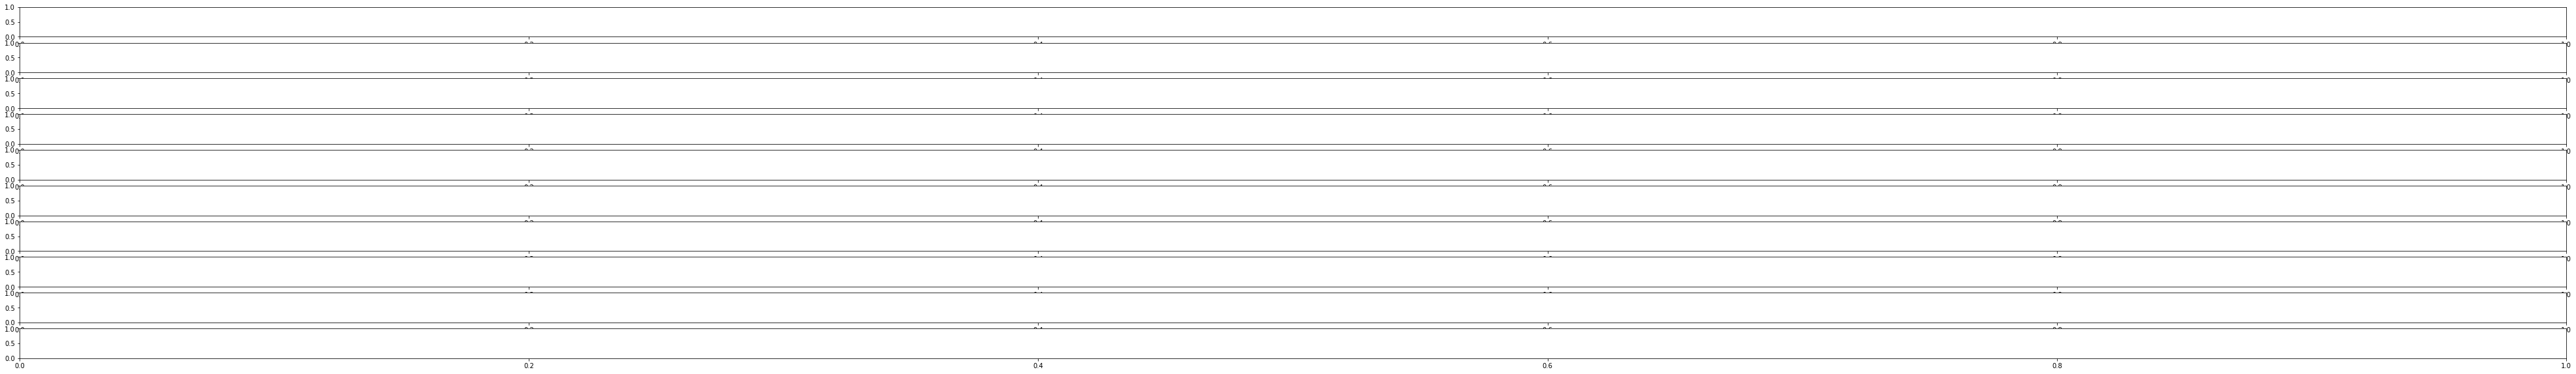

In [28]:
reporter=['l_loss','p_loss','u_loss']
epochs=200
batchsize=64
if start_e>0:
    start_e=start_e+1

data_file_l = 'ASSET_lower_temp.h5'
data_file_u = 'train_data.h5'


fit_model(model_name,data_file_l, data_file_u, epochs,reporter)